In [1]:
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS
from mmengine.config import Config
import mmcv

In [2]:
!python /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/mmdetection/demo/image_demo.py \
    /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/data_mmdetection/coco/test/S5_than_Image__2025-09-03__14-12-46_bright_2_crop_8_jpg.rf.d7005ea01036265202c246802c6e3d45.jpg \
    /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/soft_teacher_custom_40/soft_teacher_custom_40.py \
  --weights /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/soft_teacher_custom_40/epoch_1.pth --out-dir /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/ \
  --device cuda:0 --pred-score-thr 0.5 --show

Loads checkpoint by local backend from path: /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/soft_teacher_custom_40/epoch_1.pth
10/07 08:05:29 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
results have been saved at /home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/


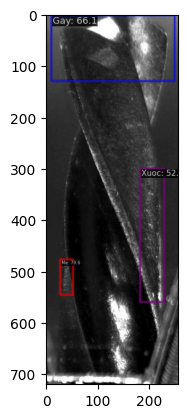

In [3]:
import matplotlib.pyplot as plt
path_img_test = "/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/data_mmdetection/coco/test/S5_than_Image__2025-09-03__14-12-46_bright_2_crop_8_jpg.rf.d7005ea01036265202c246802c6e3d45.jpg"
path_img = path_img_test.split('/')[-1]
base_path = '/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/vis'
img = mmcv.imread(f'{base_path}/{path_img}')
plt.imshow(img)
plt.show()

In [3]:
# === ĐƯỜNG DẪN CỦA BẠN ===
soft_cfg = '/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/soft_teacher_custom_40/20251007_081326/vis_data/config.py'
ckpt     = '/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/soft_teacher_custom_40/epoch_1.pth' # model trained with soft teacher
import torch

# 1) Flatten config: SoftTeacher -> detector thuần
cfg  = Config.fromfile(soft_cfg)
dcfg = cfg.copy()
dcfg.model = cfg.model.detector
for k in ['semi_train_cfg', 'semi_test_cfg']:
    if k in dcfg:
        dcfg.pop(k)
if 'data_preprocessor' in dcfg:
    dcfg.model.setdefault('data_preprocessor', dcfg['data_preprocessor'])

# 2) Init detector *không* load ckpt ở đây
model = init_detector(dcfg, checkpoint=None, device='cuda:0')  # hoặc 'cpu'

# 3) Đọc ckpt và lọc đúng nhánh (ưu tiên teacher.detector.)
raw   = torch.load(ckpt, map_location='cpu')
state = raw.get('state_dict', raw)  # nhiều ckpt lưu thẳng state_dict

def strip_prefix(state_dict, prefix):
    return {k[len(prefix):]: v for k, v in state_dict.items() if k.startswith(prefix)}

filtered = None
# Ưu tiên nhánh đầy đủ nhất
for p in ['teacher.detector.', 'teacher.', 'student.detector.']:
    sub = strip_prefix(state, p)
    if sub:
        filtered = sub
        print(f'Using prefix: {p}  ->  {len(sub)} params')
        break

# Fallback: nếu không có prefix trên, thử trường hợp ckpt đã là detector thuần
if filtered is None:
    base_ok = {'backbone','neck','rpn_head','roi_head','bbox_head'}
    filtered = {k: v for k, v in state.items() if k.split('.')[0] in base_ok}
    print('Fallback raw detector keys:', len(filtered))

# (Tuỳ) bỏ 'module.' nếu ckpt từng train với DataParallel
if any(k.startswith('module.') for k in filtered):
    filtered = {k.replace('module.', '', 1): v for k, v in filtered.items()}

missing, unexpected = model.load_state_dict(filtered, strict=False)
print('=> load_state_dict done')
print('missing:', len(missing), 'unexpected:', len(unexpected))

# 1) Ép model dùng đúng tên lớp của bạn
MY_CLASSES = ('Gay','Me','Mon_dau','Ri_set','Xuoc')
model.dataset_meta = {'classes': MY_CLASSES}

# (tuỳ chọn) nếu muốn màu đúng như config train:
MY_PALETTE = [(255,0,0),(0,0,255),(0,255,0),(255,255,0),(128,0,128)]
model.dataset_meta['palette'] = MY_PALETTE
vis = VISUALIZERS.build(model.cfg.visualizer)
vis.dataset_meta = model.dataset_meta

/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/mmdetection/mmdet/apis/inference.py:65: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')


Using prefix: teacher.  ->  348 params
=> load_state_dict done
missing: 0 unexpected: 0


/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


Saved: vis_teacher.jpg


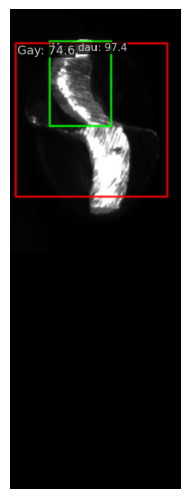

In [13]:
# 4) Inference thử
path_img = \
"/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/data_mmdetection/coco/test/S23_Image__2025-09-04__09-54-08_dark_1_crop_8_jpg.rf.be3c8b571cf6b83b4a39518f4a9b79e1.jpg"



out_path = '/home/coder/trong/KLTN_SEMI/code/Soft_Teacher/work_dirs/vis' + '/' + path_img.split('/')[-1].split('.')[0]

img = mmcv.imread(path_img)
res = inference_detector(model, img)

vis.add_datasample('res', img, data_sample=res, draw_gt=False, pred_score_thr=0.6, out_file=out_path + '_vis_teacher.jpg')
print('Saved: vis_teacher.jpg')
vis.show()